Importamos las librerías necesarias

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

Carga de datos 

In [56]:
# Cargar los datos
df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
df.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Exploración inicial del dataset

In [4]:
# Estadísticas Descriptivas
print(f"ESTADÍSTICAS DESCRIPTIVAS\n")
df.describe()

ESTADÍSTICAS DESCRIPTIVAS



,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [5]:
# Información general del dataset
print(f"INFORMACIÓN GENERAL DEL CONJUNTO DE DATOS \n")
print(df.info())

df.shape


INFORMACIÓN GENERAL DEL CONJUNTO DE DATOS 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None


(8693, 14)

Calcular el número de nulos en cada característica

In [6]:
print("VALORES FALTANTES\n")
df.isnull().sum()

VALORES FALTANTES



PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Imputación de los valores faltantes

In [7]:
# Separar variables numéricas y categóricas
numeric_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
categorical_features = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']

In [8]:
# Crear una copia del dataframe original
df_imputed = df.copy()

# Imputación simple para variables categóricas
cat_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
df_imputed[categorical_features] = cat_imputer.fit_transform(df_imputed[categorical_features])

In [9]:
# Imputación para variables numéricas
# Podemos probar diferentes métodos:

# a. Media
mean_imputer = SimpleImputer(strategy='mean')
df_imputed[numeric_features] = mean_imputer.fit_transform(df_imputed[numeric_features])

In [10]:
# 3. Imputación personalizada para 'Cabin'
def process_cabin(df):
    # Crear nuevas columnas
    df_imputed[['Deck', 'Num', 'Side']] = df_imputed['Cabin'].str.split('/', expand=True)
    
    # Imputar valores faltantes
    df_imputed['Deck'] = df_imputed['Deck'].fillna('Unknown')
    df_imputed['Side'] = df_imputed['Side'].fillna('Unknown')
    df_imputed['Num'] = pd.to_numeric(df_imputed['Num'], errors='coerce')
    
    # Calcular la mediana de 'Num' (asegurándonos de que sea un entero)
    num_median = int(df_imputed['Num'].median())
    
    # Imputar valores faltantes y convertir a entero
    df_imputed['Num'] = df_imputed['Num'].fillna(num_median).astype(int)
    
    # Reconstruir 'Cabin'
    df_imputed['Cabin'] = df_imputed['Deck'] + '/' + _imputed['Num'].astype(str) + '/' + df_imputed['Side']
    
    # Eliminar columnas temporales
    df_imputed = df.drop(['Deck', 'Num', 'Side'], axis=1)
    
    return df_imputed

df_imputed.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [11]:
# Verificar que no quedan valores faltantes
print("Valores faltantes en train_df después de imputación:")
print(df_imputed.isnull().sum())

Valores faltantes en train_df después de imputación:
PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64


Limpieza de Datos

In [17]:
# Limpiar espacios en blanco solo en las columnas que contienen strings
for column in df.columns:
    # Convertir a s_imputedring y luego reemplazar los espacios en blanco
    if df_imputed[column].dtype == 'object':
        df_imputed[column] = df_imputed[column].astype(str).str.replace(' ', '', regex=False)
        
df_imputed.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,MahamOfracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,JuannaVines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,AltarkSusent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,SolamSusent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,WillySantantines,True


Guardar los datos limpioe

In [18]:
# Guardar los datos imputados
df_imputed.to_csv('data/df_cleaned.csv', index=False)

Visualizaciones

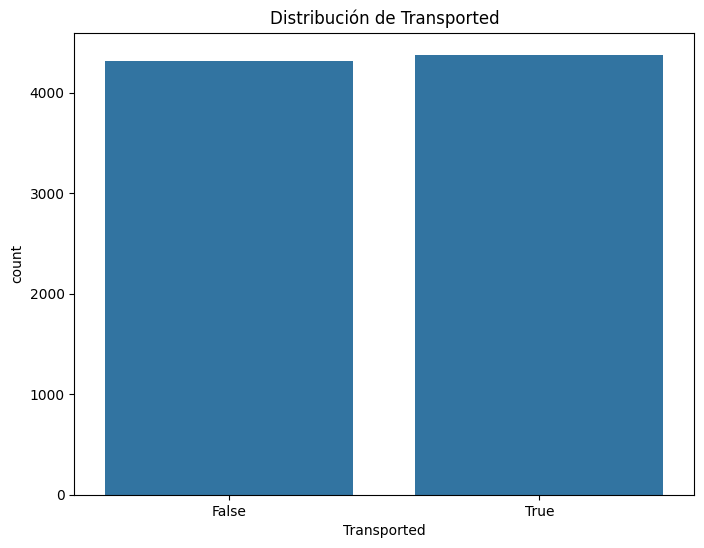

In [19]:
# Distribución de la variable objetivo
plt.figure(figsize=(8, 6))
sns.countplot(x='Transported', data=df_imputed)
plt.title('Distribución de Transported')
plt.show()

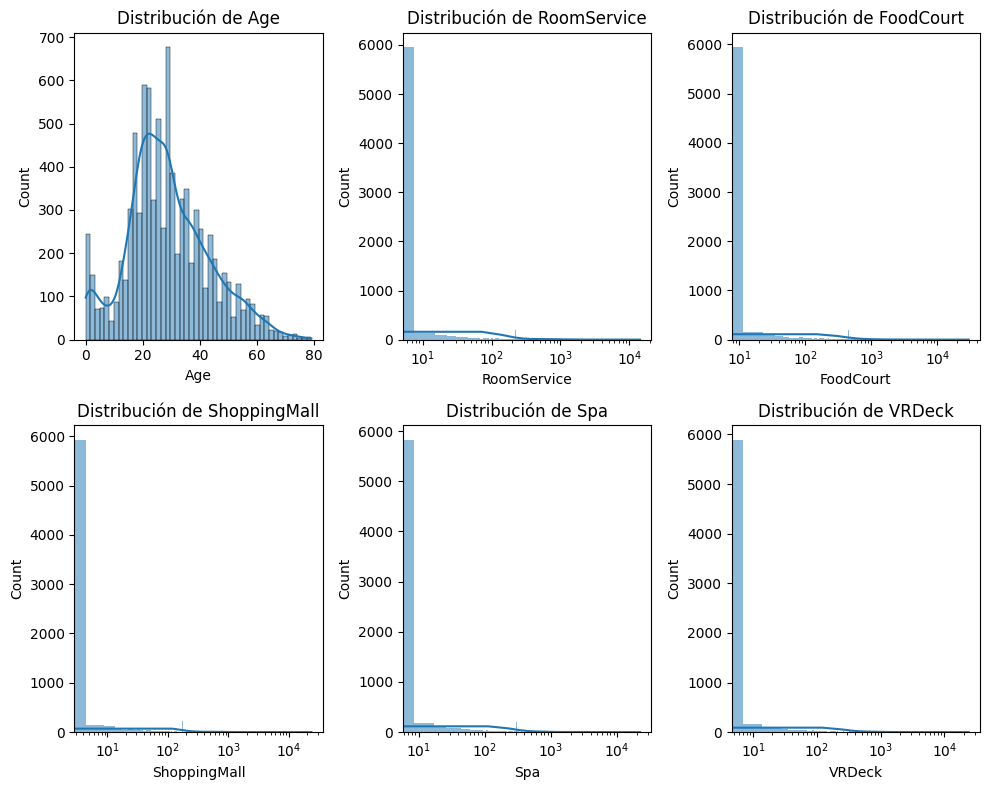

In [20]:
# Distribución de variables numéricas
numeric_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
fig, axes = plt.subplots(2, 3, figsize=(10, 8))
for i, col in enumerate(numeric_cols):
    sns.histplot(data=df_imputed, x=col, kde=True, ax=axes[i//3, i%3])
    
    if col != 'Age':  # Aplicar escala logarítmica a las otras variables
        axes[i//3, i%3].set(xscale="log")  # Escala logarítmica en el eje X para mejorar la visualización
    axes[i//3, i%3].set_title(f"Distribución de {col}")  # Asignar el título correctamente
    
plt.tight_layout()
plt.show()


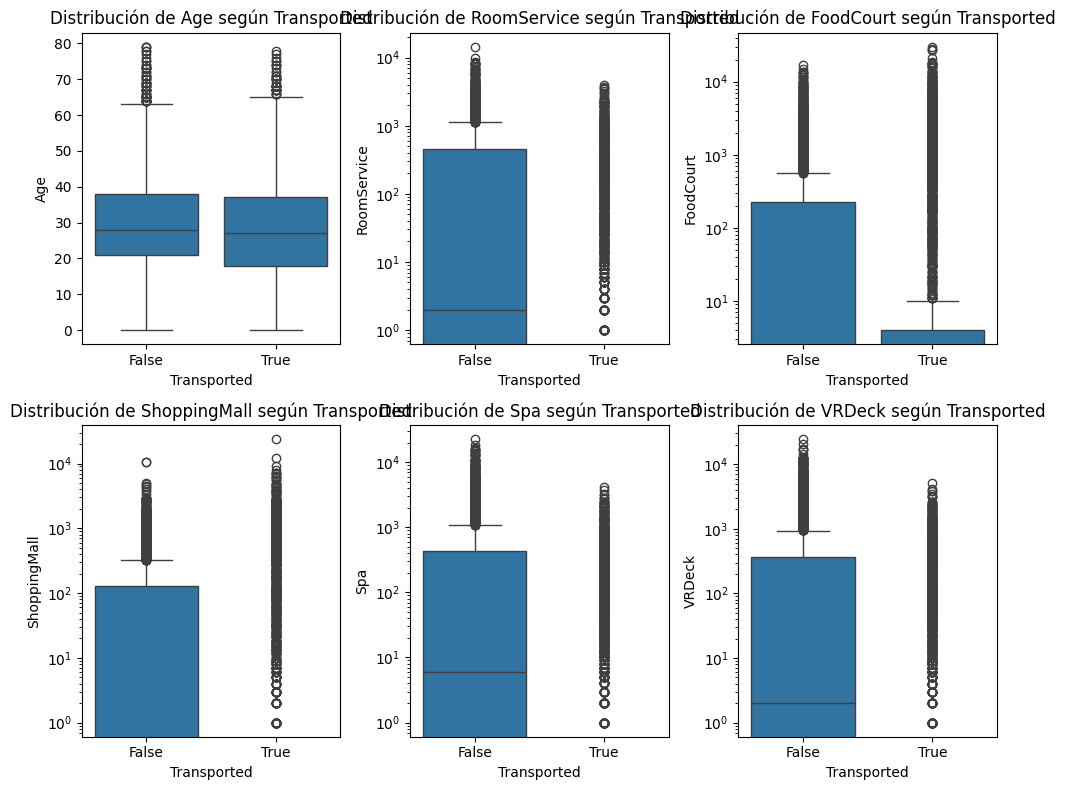

In [21]:
# Relación entre variables numéricas y la variable objetivo
fig, axes = plt.subplots(2, 3, figsize=(10, 8))
for i, col in enumerate(numeric_cols):
    sns.boxplot(x='Transported', y=col, data=df_imputed, ax=axes[i//3, i%3])
    
    if col != 'Age':  # Aplicar escala logarítmica a las otras variables
        axes[i//3, i%3].set(yscale="log")  # Escala logarítmica en el eje Y para mejorar la visualización
    axes[i//3, i%3].set_title(f"Distribución de {col} según Transported")
    
plt.tight_layout()
plt.show()

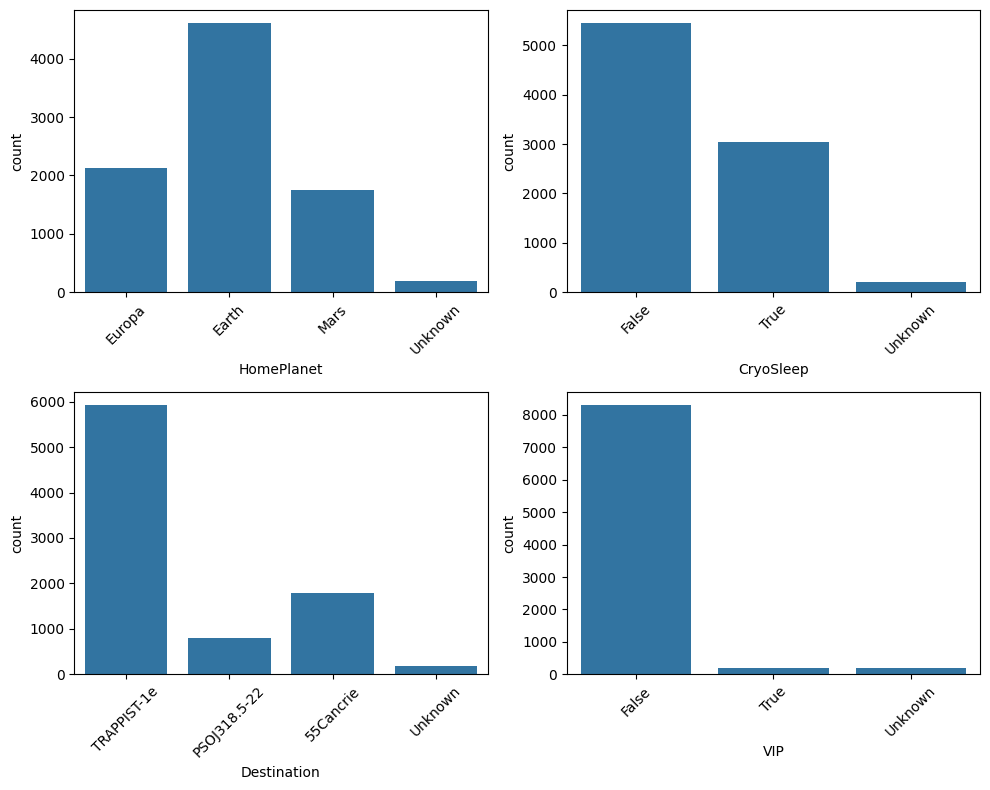

In [22]:
# Distribución de variables categóricas
cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=df_imputed, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_xticklabels(axes[i//2, i%2].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

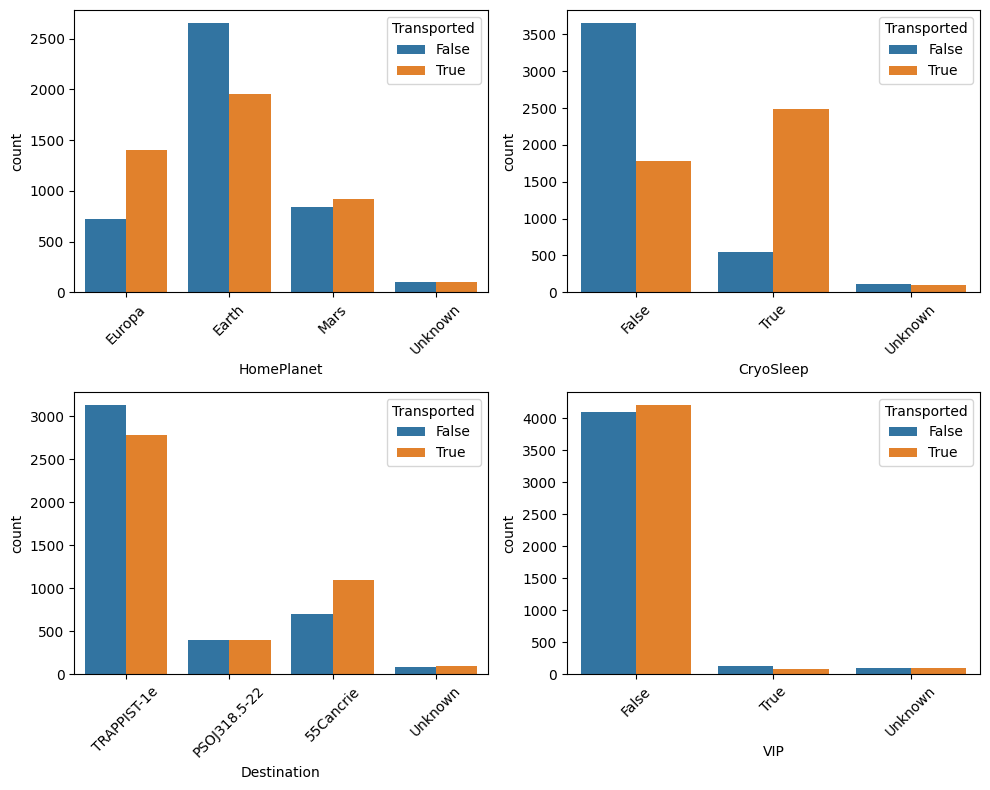

In [23]:
# Relación entre variables categóricas y la variable objetivo
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for i, col in enumerate(cat_cols):
    sns.countplot(x=col, hue='Transported', data=df_imputed, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_xticklabels(axes[i//2, i%2].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

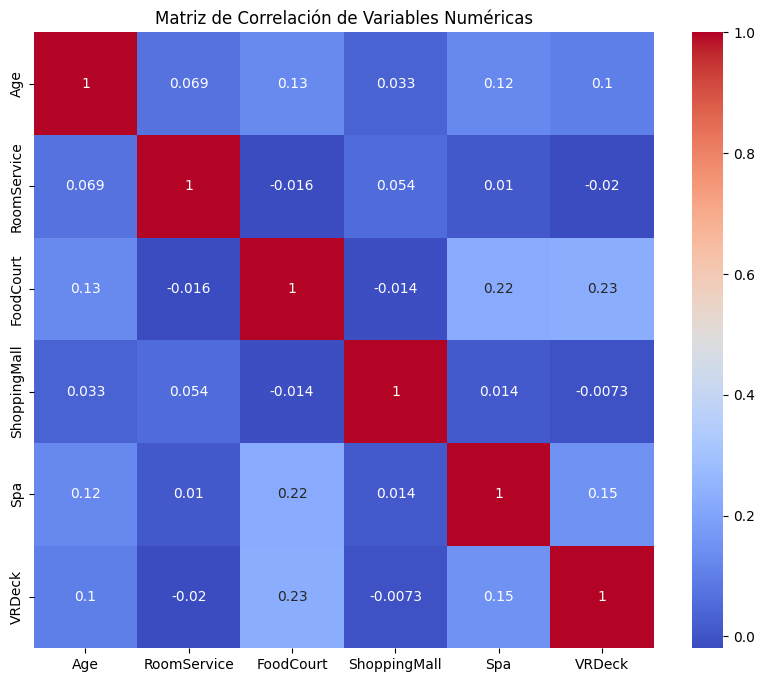

In [24]:
# Correlación entre variables numéricas
corr_matrix = df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

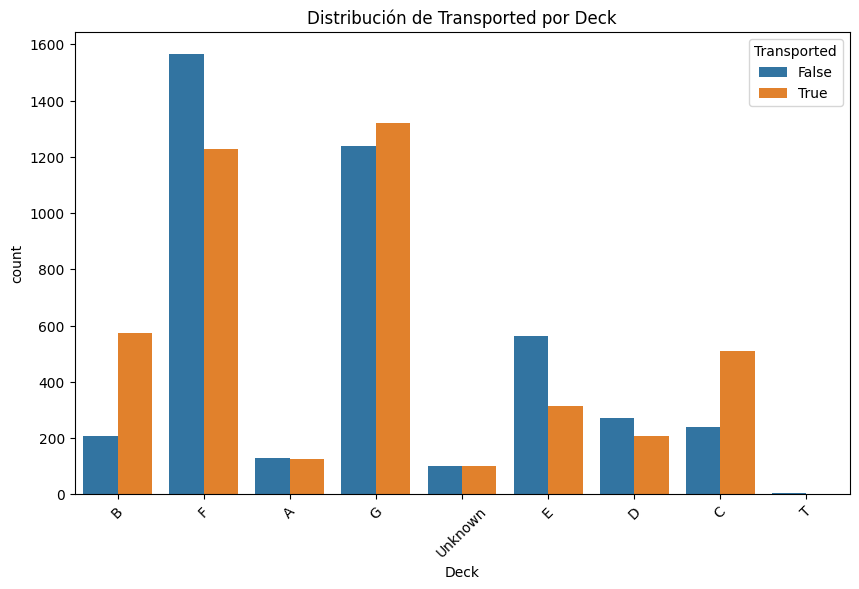

In [26]:

# Análisis de la cabina
df_imputed[['Deck', 'Num', 'Side']] = df_imputed['Cabin'].str.split('/', expand=True)
plt.figure(figsize=(10, 6))
sns.countplot(x='Deck', hue='Transported', data=df_imputed)
plt.title('Distribución de Transported por Deck')
plt.xticks(rotation=45)
plt.show()

In [27]:
# Ahora intentemos extraer GroupSize
def extract_group_size(passenger_id):
    try:
        return int(passenger_id.split('_')[0])
    except:
        return None

df_imputed['GroupSize'] = df_imputed['PassengerId'].apply(extract_group_size)
df_imputed.head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Num,Side,GroupSize
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,MahamOfracculy,False,B,0,P,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,JuannaVines,True,F,0,S,2
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,AltarkSusent,False,A,0,S,3
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,SolamSusent,False,A,0,S,3
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,WillySantantines,True,F,1,S,4


In [28]:
# Verifiquemos si tenemos algún valor None
print(df_imputed['GroupSize'].isnull().sum())

0


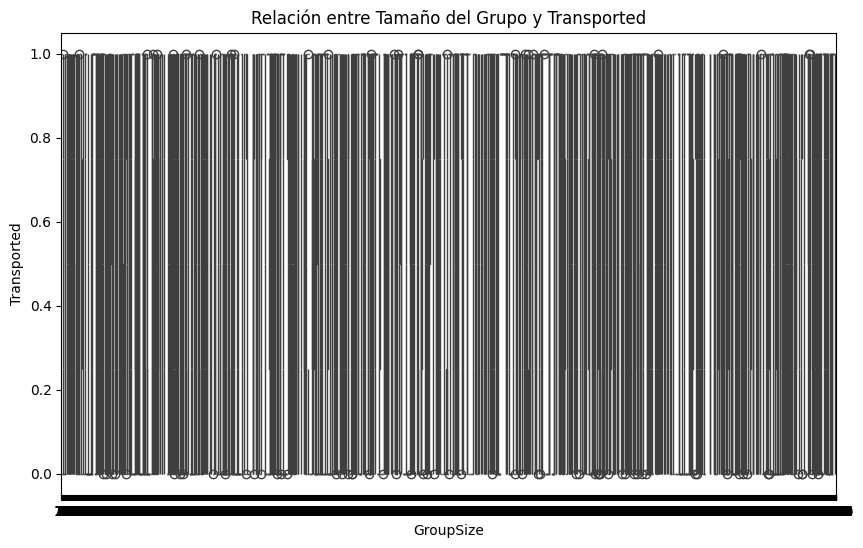

In [29]:
# Ahora creemos el gráfico
plt.figure(figsize=(10, 6))
sns.boxplot(x='GroupSize', y='Transported', data=df_imputed)
plt.title('Relación entre Tamaño del Grupo y Transported')
plt.show()

ENTRENAMIENTO DE MODELO

In [36]:
# Separar características y objetivo
X = df_imputed.drop(['Transported', 'Name', 'PassengerId'], axis=1)
y = df_imputed['Transported']
print(f"Variables Predictoras\n {X}")
X
print(f"Variables a Predicir\n {y}")
y

Variables Predictoras
      HomePlanet CryoSleep     Cabin   Destination   Age    VIP  RoomService  \
0        Europa     False     B/0/P   TRAPPIST-1e  39.0  False          0.0   
1         Earth     False     F/0/S   TRAPPIST-1e  24.0  False        109.0   
2        Europa     False     A/0/S   TRAPPIST-1e  58.0   True         43.0   
3        Europa     False     A/0/S   TRAPPIST-1e  33.0  False          0.0   
4         Earth     False     F/1/S   TRAPPIST-1e  16.0  False        303.0   
...         ...       ...       ...           ...   ...    ...          ...   
8688     Europa     False    A/98/P     55Cancrie  41.0   True          0.0   
8689      Earth      True  G/1499/S  PSOJ318.5-22  18.0  False          0.0   
8690      Earth     False  G/1500/S   TRAPPIST-1e  26.0  False          0.0   
8691     Europa     False   E/608/S     55Cancrie  32.0  False          0.0   
8692     Europa     False   E/608/S   TRAPPIST-1e  44.0  False        126.0   

      FoodCourt  ShoppingMal

0       False
1        True
2       False
3       False
4        True
        ...  
8688    False
8689    False
8690     True
8691    False
8692     True
Name: Transported, Length: 8693, dtype: bool

In [38]:
# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train\n {X_train}")
print(f"y_train\n {y_train}")
print(f"X_test\n {X_test}")
print(f"y_test\n {y_test}")

X_train
      HomePlanet CryoSleep     Cabin   Destination   Age      VIP  RoomService  \
2333      Earth     False   Unknown   TRAPPIST-1e  28.0    False     0.000000   
2589      Earth     False   F/575/P   TRAPPIST-1e  17.0    False     0.000000   
8302     Europa      True   C/329/S     55Cancrie  28.0    False     0.000000   
8177       Mars     False  F/1800/P   TRAPPIST-1e  20.0    False   224.687617   
500      Europa      True    C/18/P     55Cancrie  36.0    False     0.000000   
...         ...       ...       ...           ...   ...      ...          ...   
5734      Earth   Unknown   G/988/S   TRAPPIST-1e  18.0    False    14.000000   
5191       Mars     False  F/1063/S   TRAPPIST-1e  50.0  Unknown   690.000000   
5390      Earth     False  F/1194/P  PSOJ318.5-22  22.0    False   158.000000   
860        Mars     False   F/191/P   TRAPPIST-1e  34.0    False   379.000000   
7270     Europa     False   C/253/P     55Cancrie  28.0    False     7.000000   

      FoodCourt  S

In [52]:
y_test

304      True
2697    False
8424    False
1672     True
8458     True
        ...  
7175    False
3187     True
1302    False
5934     True
6093    False
Name: Transported, Length: 1739, dtype: bool

In [39]:
# Definir columnas numéricas y categóricas
numeric_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin']


In [40]:
# Crear preprocesadores
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [41]:
# Combinar preprocesadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [42]:
# Definir los modelos a probar
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(random_state=42)
}

In [43]:
def evaluate_model(model, X, y):   
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
    return scores.mean(), scores.std()

In [44]:
# Evaluar cada modelo
results = {}
for name, model in models.items():
    mean_score, std_score = evaluate_model(model, X, y)
    results[name] = (mean_score, std_score)
    print(f"{name}: Accuracy = {mean_score:.4f} (+/- {std_score:.4f})")


Logistic Regression: Accuracy = 0.7874 (+/- 0.0083)
Decision Tree: Accuracy = 0.7671 (+/- 0.0144)
Random Forest: Accuracy = 0.7893 (+/- 0.0076)
Gradient Boosting: Accuracy = 0.7925 (+/- 0.0100)
SVM: Accuracy = 0.7891 (+/- 0.0045)
KNN: Accuracy = 0.7620 (+/- 0.0048)
XGBoost: Accuracy = 0.7860 (+/- 0.0122)


In [45]:
# Encontrar el mejor modelo
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

print(f"\nEl mejor modelo es: {best_model_name}")


El mejor modelo es: Gradient Boosting


In [46]:
# Entrenar el mejor modelo en todo el conjunto de datos
best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])
best_pipeline.fit(X, y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP',
                                                   'Cabin'])])),
                ('classifier', GradientBoostingClassifier(random_state=42))])

In [47]:
# Hacer predicciones en el conjunto de entrenamiento
y_pred = best_pipeline.predict(X)
y_pred

array([ True, False, False, ...,  True, False,  True])

In [48]:

print("\nMétricas del mejor modelo:")
print(f"Accuracy: {accuracy_score(y, y_pred):.4f}")
print(f"Precision: {precision_score(y, y_pred):.4f}")
print(f"Recall: {recall_score(y, y_pred):.4f}")
print(f"F1-score: {f1_score(y, y_pred):.4f}")



Métricas del mejor modelo:
Accuracy: 0.8102
Precision: 0.7876
Recall: 0.8531
F1-score: 0.8191


In [57]:
# Preparar los datos de prueba
X_test = test_df.drop(['Name', 'PassengerId'], axis=1)
X_test

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0
1,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0
2,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0
3,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0
4,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4272,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0
4273,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0
4274,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0
4275,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0


In [58]:
# Hacer predicciones en los datos de prueba
test_predictions = best_pipeline.predict(X_test)
test_predictions

array([ True, False,  True, ...,  True,  True,  True])

In [60]:
# Crear el archivo de envío
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Transported': test_predictions
})
submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [61]:
#submission['Transported'] = submission['Transported'].map({True: True, False: False})
submission.to_csv('data/submission_v2.csv', index=False)
print("Archivo de envío creado: submission_v2.csv")

Archivo de envío creado: submission_v2.csv
